## Proj5
本项目通过程序仿真的方式实现了光束在自由空间中衍射的过程，衍射过程可以通过衍射光学元件 (Diffractive Optical Elements, DOE)人为调控，DOE通常采用微纳刻蚀工艺构成二维分布的衍射单元，每个衍射单元可以有特定的形貌、折射率等，对激光波前位相分布进行精细调控。激光经过每个衍射单元后发生衍射，并在一定距离（通常为无穷远或透镜焦平面）处产生干涉，形成特定的光强分布。

本项目基于光学神经网络实现了在手写数字识别数据集(MNIST)上的图像分类功能。你需要完成student_code.py中的commplex_exp_torch、ifftshift2d_tf、transp_ifft2d、transp_fft2d四个函数，感受通过梯度下降的方式优化硬件参数设计的过程。

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
import os
from tqdm.notebook import tqdm
from student_code import *

#####################################################
# 固定参数，不需要调整
padamt = 80
otf_size = 142
classes = 10

#####################################################
train_batch_size = 128
test_batch_size = 64  

learning_rate = 0.00001 

#####################################################
train_dataset = MyDataset(train=True)
test_dataset = MyDataset(train=False)

train_loader = DataLoader(dataset=train_dataset, batch_size=train_batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=test_batch_size, shuffle=False, pin_memory=True)


In [2]:
#调用GPU
# os.environ["CUDA_VISIBLE_DEVICES"]="1"
device = torch.device("cuda")
torch.cuda.empty_cache()        #释放显存

model = onn()
model.to(device)

#####################################################
# 构建损失函数
criterion = torch.nn.CrossEntropyLoss()      #交叉熵
# 构建优化器
optimizer = optim.SGD(model.parameters(),lr=learning_rate,momentum=0.5)    #带动量0.5
# 设置学习率梯度下降，如果连续2个epoch测试准确率没有上升，则降低学习率，系数0.5
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True, threshold=0.00005, threshold_mode='rel', cooldown=0, min_lr=1e-7, eps=1e-08)

#####################################################
train_epoch = []
model_accuracy = []
temp_acc = 0.0
train_loss_val = []
max_acc = 0

/data/lilinwei/.conda/envs/wan21/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [3]:
def train(epoch):
    running_loss =0.0
    for batch_idx,data in enumerate(train_loader,0):
        inputs,target = data
        inputs,target = inputs.to(device),target.to(device)
        optimizer.zero_grad()

        #forward,backward,update
        outputs = model(inputs)
        outputs = img_split(outputs)

        loss = criterion(outputs,target)
        loss.backward()
        optimizer.step()

        running_loss+=loss.item()

    tqdm.write('loss: %.3f' % (loss.item()))

In [4]:
def test():
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images,labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            outputs = img_split(outputs)
            
            _, predicted = torch.max(outputs.data,dim=1)       #从第一维度开始搜索
            _, labels = torch.max(labels, dim=1)
            total += labels.size(0)
            correct += (predicted==labels).sum().item()
    tqdm.write('Accuracy on test set: %f %% [%d/%d]' % (100 * correct / total, correct, total))

    return correct/total

In [5]:
for epoch in tqdm(range(30)):
    tqdm.write('Epoch: %d' % (epoch + 1))
    train(epoch)
    acc = test()

    if acc > max_acc:
        max_acc = acc
    train_epoch.append(epoch)
    model_accuracy.append(acc)
    scheduler.step(acc)
print('acc:', max_acc)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1
loss: 0.434
Accuracy on test set: 85.230000 % [8523/10000]
Epoch: 2
loss: 0.419
Accuracy on test set: 87.980000 % [8798/10000]
Epoch: 3
loss: 0.388
Accuracy on test set: 87.120000 % [8712/10000]
Epoch: 4
loss: 0.365
Accuracy on test set: 90.460000 % [9046/10000]
Epoch: 5
loss: 0.395
Accuracy on test set: 88.040000 % [8804/10000]
Epoch: 6
loss: 0.495
Accuracy on test set: 91.310000 % [9131/10000]
Epoch: 7
loss: 0.538
Accuracy on test set: 90.280000 % [9028/10000]
Epoch: 8
loss: 0.476
Accuracy on test set: 89.780000 % [8978/10000]
Epoch: 9
loss: 0.416
Accuracy on test set: 87.720000 % [8772/10000]
Epoch: 10
loss: 0.358
Accuracy on test set: 92.110000 % [9211/10000]
Epoch: 11
loss: 0.325
Accuracy on test set: 92.860000 % [9286/10000]
Epoch: 12
loss: 0.295
Accuracy on test set: 92.360000 % [9236/10000]
Epoch: 13
loss: 0.313
Accuracy on test set: 93.340000 % [9334/10000]
Epoch: 14
loss: 0.241
Accuracy on test set: 93.650000 % [9365/10000]
Epoch: 15
loss: 0.261
Accuracy on test set:

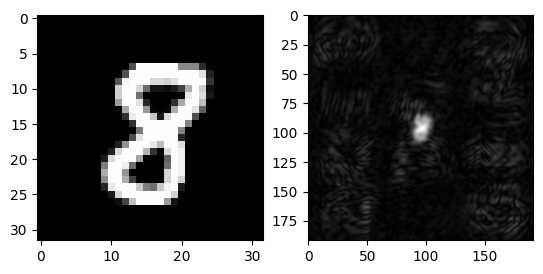

In [10]:
dataiter = iter(train_loader)
images, labels = next(dataiter)  # 随机获取部分数据
image = images[0:2].to(device)

# 现在你可以将图片送入模型
output = model(image)
plt.subplot(1,2,1)
plt.imshow(image[0].reshape(32,32).cpu().numpy(), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(output[0].squeeze().cpu().detach().numpy(), cmap='gray')
plt.show()